<a href="https://colab.research.google.com/github/iiserkbikram/Deep-Learning-Collections/blob/main/Brain_Tumor_Detection_from_Brain_MRI_Images_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.express as px
from tqdm import *
import cv2
from PIL import Image
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [4]:
! unzip /content/brain_tumor_datasets.zip.zip

Archive:  /content/brain_tumor_datasets.zip.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_dataset/no/28 n

**Checking data distribution**

In [5]:
# defining main directory
main_directory = '/content/brain_tumor_dataset'
# checking classes names
class_names = sorted(os.listdir(main_directory))
# checking number of classes
n_classes = len(class_names)

# class distribution 
class_diss = [len(os.listdir(main_directory + '/' + name)) for name in class_names]
print(f"Total Number of classes : {n_classes} \nClasse Names : {class_names}")

Total Number of classes : 2 
Classe Names : ['no', 'yes']


In [6]:
# Visualizing class distribution 
fig = px.pie(names=class_names, values=class_diss, title="Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show()

In [7]:
# Inspect the raw data before preprocessing
def view_random_image():
    
    subdirs = ['yes/','no/']
    subdir = np.random.choice(subdirs)
    target_folder = main_directory +'/' + subdir
    
    random_image = random.sample(os.listdir(target_folder), 1)
    
    img = cv2.imread(target_folder+random_image[0])
    plt.imshow(img, cmap="gray")
    plt.axis(False)
    plt.title(img.shape)
    plt.show()

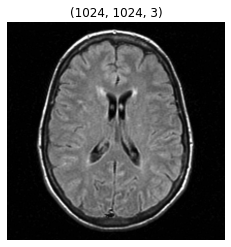

In [8]:
# View Random Image
view_random_image()

**Normalisation and Augmentation**

In [9]:
!pip install simpleitk
!pip install dltk

import SimpleITK as sitk
import os
import pandas as pd

from matplotlib import pyplot as plt

from dltk.io.augmentation import *
from dltk.io.preprocessing import *

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 11.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.7/294.7 KB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.4 MB/s eta 0:00:00
  Created wheel for dltk: filename=dltk-0.2.1-py2.py3-none-any.whl size=37274 sha256=8bc61750d1d00ff7efb35efb7bc63cebb1d410aa2d3750bc4e07c9a643c932be
  Stored in directory: /root/.cache/pip/wheels/57/41/a8/cbb3073c0af0cca129fd289f08ee36447bd6d4e747ade12629
Successfully built dltk


In [10]:
#Transfer 'jpeg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpeg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

tumor_no = np.array(Dataset_loader('/content/brain_tumor_dataset/no',224))
tumor_yes = np.array(Dataset_loader('/content/brain_tumor_dataset/yes',224))




100%|██████████| 155/155 [00:00<00:00, 99787.74it/s]


In [11]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image